
by Stuart Miller, Paul Adams, and Justin Howard

# **Introduction**

Intro

# **Methods**

## **Data**

Banking data, we don't know anything about the data!

## **Models**

This case study we use random forest, XGBoost, and support vector machines to model the data.
In the following sections, we descibe how these models work.

### **Random Forest**

A random forest is an emsemble model created from a collection of decision trees and bootstrapped aggregated (bagged) data.
The following steps are used to create bagged trees (James et al, 2013):

  * bootstrap sample (repeated sampling with replacement) the dataset to create $B$ separate datasets.
  * fit a model $f^b(x)$ on each $B$ dataset.

Then the regression bagged model is given by

$$
f_{bag}(x) = \frac{1}{B} \sum_{b=1}^B f^b (x)
$$

In the context of classification, the *majority vote* of the classifiers is taken as the class prediction.
This is called a bagged decision tree model.
The aggregation of these high variance decision trees substantially reduces the overall model variance (James et al, 2013).
In general, a large number of decision tree used be used in the ensemble.
We treat the number of decision trees as a hyperparameter and tune it with cross-validation.

One additional tweek is added to a bagged decision tree to make it a random forest.
When building decision trees, at each split, the decision tree only considers a random subset of the available predictors (James et al, 2013).
This improves on the bagged model by decorrelating the individual trees used in the ensemble.
Two common methods for determing the number of predictors to consider in a split are the square root of the number of available features
 and log base-2 of the number of available features.
We treat the number of features the model considers at each split as a hyperparameter and tune it with cross-validation.




### **XGBoost**

[XGB](https://towardsdatascience.com/from-zero-to-hero-in-xgboost-tuning-e48b59bfaf58)

### **SVM**

However, the complexity of the SVM should be considered.
The SVM implementation used in this case study, (Chang & Lin, 2011), 
 is expected to have a complexity between $O\left(p \times n^2\right)$ and $O\left(p \times n^3\right)$, 
 where $p$ is the number of features and $n$ is the number of training examples.

## **Hyperparameter Tuning**

Hyperparameters were selected with a randomized search with 5-fold internal cross-validation.
We used a randomized search rather than an exhaustive search (sometimes called grid search) 
 because randomized searches have been shown to achieve similar results,
 but with significantly lower run times than exhaustive search.
Unlike in an exhaustive search where all possible combinations of tuning parameters are validated,
 in a randomized search a number of search iterations are specified and
 a random set of parameters are validated on each iteration
In this application of randomized search, 5-fold cross-validation is performed at each iteration.
The best parameters from the search are selected based on the mean cross-validated log loss.

We ran the random forest and XGBoost hyperparameter searches for 100 iterations.
We only ran the SVM hyperparameter search for 10 iterations due to the high run time of fitting the model.
The tuning parameters for each model used in the case study are shown in tables X-Z.


**Table X. Random Forest Tuning Parameters**

| Parameter           | Search Range                    | Description |
|---------------------|:-------------------------------:|---------------------|
| `n_estimators`      | 10:150                          | Number of decision trees to use in the random forest |
| `criterion`         | `'gini'` or `'entropy'`         | The method for determining best split in decision trees |
| `max_depth`         | 10:100                          | The maximum depth decision trees can grow |
| `min_samples_split` | 2:100                           | The minimum number of samples required to make a split |
| `min_samples_leaf`  | 2:100                           | The minimum number of sample required to make a leaf node |
| `max_features`      | One of `'auto', 'sqrt', 'log2'` | The maximum number of features considered when making a split in a tree |

**Table Y. XGBoost Tuning Parameters**

| Parameter           | Search Range                    | Description |
|---------------------|:-------------------------------:|---------------------|
| `A`      |                        |  |
| `B`         | One of       |  |


**Table Z. SVM Tuning Parameters**

| Parameter | Search Range                                | Description |
|-----------|:-------------------------------------------:|---------------------|
| `C`       | 0.001:10\*                                  | The regularization strength |
| `kernel`  | One of `'linear', 'poly', 'rbf', 'sigmoid'` | The SVM kernel |
| `gamma`   | `'scale'`or `'auto'`                    | The kernel coefficient setting for `'poly', 'rbf',` and `'sigmoid'` |

\*value distibution on a log scale

# **Results**

## **Hyperparameters**

Hyperparameters selected by 5-fold CV in a randomized search

**Table XX. Tuned Random Forest Hyperparameters**

| Parameter           | Value                           |
|---------------------|:-------------------------------:|
| `n_estimators`      | 132                             |
| `criterion`         | `'gini'`                        |
| `max_depth`         | 83                              |
| `min_samples_split` | 2                               |
| `min_samples_leaf`  | 83                              |
| `max_features`      | `'sqrt'`                        |

**Table YY. Tuned XGBoost HyperParameters**

| Parameter           | Search Range                    |
|---------------------|:-------------------------------:|
| `A`      |      something                  |
| `B`         | somethign       |

**Table Z. Tuned SVM HyperParameters**

| Parameter | Search Range                                |
|-----------|:-------------------------------------------:|
| `C`       | 0.5                                          |
| `kernel`  | `'rbf'` |
| `gamma`   | `'auto'`                                    |

## **Validation Results**

Tested on the same out-of-fold test set

| Model     | Accuracy                 | Log Loss |
|-----------|-------------------------:|----------------:|
| Random Forest      | 0.7   | 7.64 |
| XGBoost            | XX    | XX |
| SVM                | XX    |  XX |




## **Complexity and Scaling**

As mentioned previously, we expect a complexity between $O \left(n^2 \right)$ and $O \left(n^3 \right)$ 
 from the implemetation of the SVM used in this case study.
We fit an SVM on subsets of the data with the following sizes: 1,000, 2,000, 5,000, 7,000, 10,000.
The fit times for the SVM is plotted vs the number or records in Fig. X.
A quadratic fit is overlayed on the plot of the SVM observations in Fig. X.
The quadratic appears to be reasonable for these dataset sizes, confirming our expectation of the SVM complexity.

For comparison, we also recorded the fit times for a random forest over the dataset sizes.
While the SVM has lower fit times for the smaller datasets (less than 7000 records),
 the random forest appears to exhibit a linear relationship between the number of records and
 fit time.
We also overlayed a linear fit on the plot of the random forest observations in Fig. X.
The linear fit appears to be reasonable for these dataset sizes.


![RF_and_SVM_with_fits](./images/RF_SVM_Fits_Small.png)

The fit times with fits for SVM and random forest extended up to 70,000 records 
 (the approximate size of the training data)
 are shown in Fig. X.
This figure shows how the extent to which the training times of the SVM and random forest diverge with 

![RF_and_SVM_extended](./images/RF_SVM_Fits.png)


In addition, to having lower fit times than the SVM, the random forest can be distributed over multiple cores.
The parallelization of an algorithm can dramatically reduce fit times.
We show the effect of distributing the training on multiple cores in Fig. X.

![RF_Parallel](./images/RF_profile.png)

# **Conclusion**

the conclusion

## References

Chang, C.C., & Lin, C.J. (2011). LIBSVM: A library for support vector machinesACM Transactions on Intelligent Systems and Technology, 2, 27:1–27:27.

James, G., Witten, D., Hastie, T., Tibshirani, R. (2013). An Introduction to Statistical Learning: with Applications in R . Springer.

# Appendix A

In [90]:
import time
import pprint
import os

import numpy as np
import numpy.polynomial.polynomial as poly
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    log_loss,
    accuracy_score,
    make_scorer)
from sklearn.model_selection import (
    train_test_split, 
    RandomizedSearchCV, 
    cross_validate)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

log_loss_scorer = make_scorer(log_loss, greater_is_better=False)
accuracy_scorer = make_scorer(accuracy_score)

random_state = np.random.RandomState(42)

In [2]:
# get the data
data = pd.read_csv('./data/case_8.csv')
# put the target in another variable
target = data.target
# drop off ID and target
data = data.drop(['ID', 'target'], axis=1)
# get train and test sets
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    target,
                                                    test_size=0.33,
                                                    random_state=random_state)

In [3]:
obj_columns = list(data.select_dtypes(include='object'))
obj_col_encoders = {col: LabelEncoder() for col in obj_columns}

for col in obj_col_encoders.keys():
    obj_col_encoders[col].fit(data[col])
    
for col in obj_col_encoders.keys():
    X_train[col] = obj_col_encoders[col].transform(X_train[col])
    X_test[col] = obj_col_encoders[col].transform(X_test[col])

/home/stuart/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stuart/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


**Random Forest Code**

In [4]:
# random forest

rf_clf = RandomForestClassifier(random_state=random_state)
rf_params = {
    'n_estimators': np.linspace(10, 150, dtype='int'),
    'criterion':['gini', 'entropy'],
    'max_depth': np.linspace(10, 100, dtype='int'),
    'min_samples_split': np.linspace(2, 100, 50, dtype='int'),
    'min_samples_leaf': np.linspace(2, 100, 50, dtype='int'),
    'max_features': ['auto', 'sqrt', 'log2']
}

search_iters = 100

rf_RSCV_start_time = time.time()
# setup search
rf_RSCV = RandomizedSearchCV(rf_clf, rf_params, scoring=log_loss_scorer,
                                 n_iter=search_iters, random_state=random_state)
# seach
rf_RSCV.fit(X_train, y_train)

rf_RSCV_end_time = time.time()
duration = rf_RSCV_end_time-rf_RSCV_start_time

print(f'Randomized CV search done. {search_iters} iterations took \
{int(duration // 3600):02d}::{int((duration % 3600)//60):02d}::{int((duration % 3600) % 60):02d}')

Randomized CV search done. 100 iterations took 03::53::19


In [5]:
# print the best parameters chosen by CV
pprint.pprint(rf_RSCV.best_params_)

{'criterion': 'gini',
 'max_depth': 83,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 48,
 'n_estimators': 132}


In [6]:
# get CV results with best parameters
rf_clf.set_params(**rf_RSCV.best_params_)
rf_cv = cross_validate(rf_clf, X_train, y_train, 
                       scoring={
                           'log_loss':log_loss_scorer,
                           'accuracy':accuracy_scorer
                       })

In [7]:
print('RF 5-fold Validation Performance')
# note test_log_loss is negated due to how scorers work 
# in parameter searches in sklearn
print('Mean Log Loss\t{}'.format(np.mean(-rf_cv['test_log_loss'])))
print('Mean Accuracy\t{}'.format(np.mean(rf_cv['test_accuracy'])))

RF 5-fold Validation Performance
Mean Log Loss	7.697942288341889
Mean Accuracy	0.777126444284875


In [8]:
# get performance on test set
rf_clf.fit(X_train, y_train)
rf_y_test_pred = rf_clf.predict(X_test)

print('RF Test Set Performance')
print('Test Log Loss\t{}'.format(log_loss(rf_y_test_pred, y_test)))
print('Test Accuracy\t{}'.format(accuracy_score(rf_y_test_pred, y_test)))

RF Test Set Performance
Test Log Loss	7.640917295253621
Test Accuracy	0.7787732598208132


In [95]:
# do some fit times for comparison with the SVM
cpuCount = os.cpu_count()
cores, sizes, times = list(), list(), list()
for n_cores in [i for i in range(1, cpuCount + 1)]:
    for size in [1000, 2000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 45000, 60000, 70000]:
        rf_clf = RandomForestClassifier(random_state=random_state)
        rf_clf.set_params(**best_params)
        rf_clf.set_params(**{'n_jobs': n_cores})
        sample = random_state.choice(np.arange(len(X_train)), size=size, replace=False)
        X_train_sub = X_train.iloc[sample, :]
        y_train_sub = y_train.iloc[sample]
        start_time = time.time()
        rf_clf.fit(X_train_sub, y_train_sub)
        end_time = time.time()
        duration = end_time - start_time
        print(f'RF fit on {size} records with {n_cores} took {duration}')
        cores.append(n_cores)
        sizes.append(size)
        times.append(duration)

RF fit on 1000 records with 1 took 0.4796421527862549
RF fit on 2000 records with 1 took 0.9080703258514404
RF fit on 5000 records with 1 took 2.67579984664917
RF fit on 7000 records with 1 took 3.7967145442962646
RF fit on 10000 records with 1 took 5.671120882034302
RF fit on 15000 records with 1 took 9.404758214950562
RF fit on 20000 records with 1 took 13.622686862945557
RF fit on 25000 records with 1 took 17.721182823181152
RF fit on 30000 records with 1 took 21.653369188308716
RF fit on 45000 records with 1 took 34.87429761886597
RF fit on 60000 records with 1 took 50.072606563568115
RF fit on 70000 records with 1 took 59.89445900917053
RF fit on 1000 records with 2 took 0.36624670028686523
RF fit on 2000 records with 2 took 0.6714990139007568
RF fit on 5000 records with 2 took 1.46970534324646
RF fit on 7000 records with 2 took 2.1750667095184326
RF fit on 10000 records with 2 took 3.273986577987671
RF fit on 15000 records with 2 took 4.983263254165649
RF fit on 20000 records wit

In [105]:
time_data = pd.DataFrame({
    'cores':cores,
    'sizes':sizes,
    'times':times})

# save the profile for later
#time_data.to_csv('./data/RF_profiling.csv')

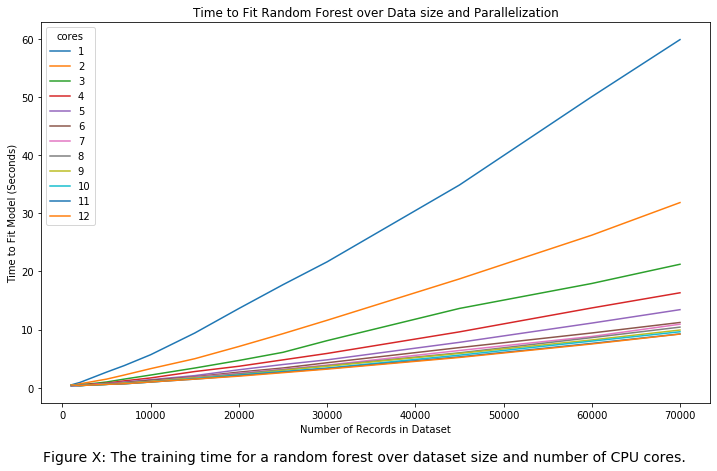

In [196]:
time_data = pd.read_csv('./data/RF_profiling.csv')
df = time_data.pivot(index='sizes', columns='cores', values='times')

df.plot(figsize = (12,7))
plt.ylabel('Time to Fit Model (Seconds)')
plt.xlabel('Number of Records in Dataset')
plt.title('Time to Fit Random Forest over Data size and Parallelization');
caption = 'Figure X: The training time for a random forest over dataset size and number of CPU cores.'
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=14);
plt.savefig('./images/RF_profile.png')

**SVM Code**

In [ ]:
svc_clf = SVC(random_state=random_state)
svc_params = {
    'C': np.geomspace(0.001, 10, dtype='float'),
    'kernel':['linear', 'poly', 'rbf','sigmoid'],
    'gamma':['scale','auto']
}

search_iters = 10

svc_RSCV_start_time = time.time()
# setup search
svc_RSCV = RandomizedSearchCV(svc_clf, svc_params, scoring=log_loss_scorer,
                                 n_iter=search_iters, random_state=random_state,
                                 verbose=2, n_jobs=3)
# seach
svc_RSCV.fit(X_train, y_train)

svc_RSCV_end_time = time.time()
duration = svc_RSCV_end_time-svc_RSCV_start_time

print(f'\nRandomized CV search done. {search_iters} iterations took \
{int(duration // 3600):02d}::{int((duration % 3600)//60):02d}::{int((duration % 3600) % 60):02d}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


In [ ]:
# print the best parameters chosen by CV
pprint.pprint(svc_RSCV.best_params_)

In [ ]:
# get CV results with best parameters
svc_clf.set_params(**svc_RSCV.best_params_)
svc_cv = cross_validate(svc_clf, X_train, y_train, 
                       scoring={
                           'log_loss':log_loss_scorer,
                           'accuracy':accuracy_scorer
                       })

In [ ]:
print('\nSVM 5-fold Validation Performance')
# note test_log_loss is negated due to how scorers work 
# in parameter searches in sklearn
print('Mean Log Loss\t{}'.format(np.mean(-svc_cv['test_log_loss'])))
print('Mean Accuracy\t{}'.format(np.mean(svc_cv['test_accuracy'])))

In [ ]:
# get performance on test set
svc_clf.fit(X_train, y_train)
svc_y_test_pred = svc_clf.predict(X_test)

print('\nSVM Test Set Performance')
print('Test Log Loss\t{}'.format(log_loss(svc_y_test_pred, y_test)))
print('Test Accuracy\t{}'.format(accuracy_score(svc_y_test_pred, y_test)))

In [115]:
svc_clf.set_params()
sizes, times = list(), list()
# do some fit times for comparison with the SVM
for size in [1000, 2000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 45000, 60000, 70000]:
    sample = random_state.choice(np.arange(len(X_train)), size=size, replace=False)
    X_train_sub = X_train.iloc[sample, :]
    y_train_sub = y_train.iloc[sample]
    start_time = time.time()
    svc_clf.fit(X_train_sub, y_train_sub)
    end_time = time.time()
    duration = end_time - start_time
    print(f'SVM fit on {size} records took {duration}')
    sizes.append(size)
    times.append(duration)

SVM fit on 1000 records took 0.08845829963684082
SVM fit on 2000 records took 0.28565478324890137
SVM fit on 5000 records took 1.8542628288269043
SVM fit on 7000 records took 3.748563051223755
SVM fit on 10000 records took 8.55801510810852
SVM fit on 15000 records took 23.084169149398804
SVM fit on 20000 records took 43.611489057540894
SVM fit on 25000 records took 70.7699248790741
SVM fit on 30000 records took 102.66284823417664
SVM fit on 45000 records took 235.5498080253601
SVM fit on 60000 records took 414.73708176612854
SVM fit on 70000 records took 597.893278837204


In [118]:
time_data = pd.DataFrame({
    'sizes':sizes,
    'times':times})

# save the profile for later
time_data.to_csv('./data/SVM_profiling.csv')

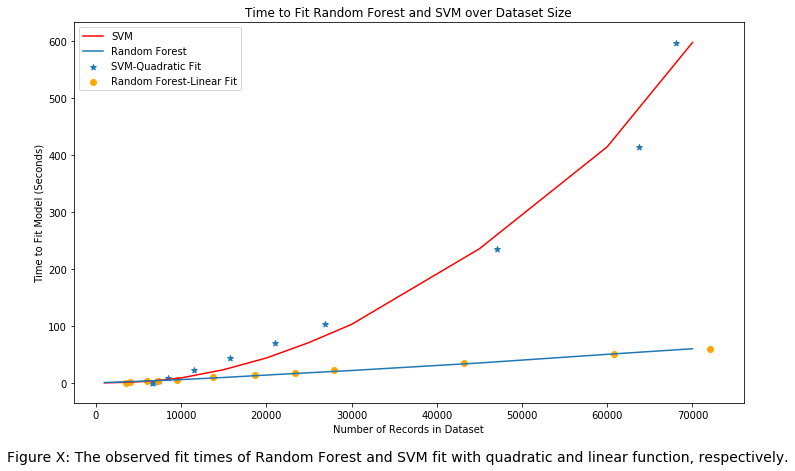

In [197]:
RF_times = pd.read_csv('./data/RF_profiling.csv').query('cores == 1')
time_data = pd.read_csv('./data/SVM_profiling.csv')

svm_coefs = poly.polyfit(time_data.times, time_data.sizes, 2)
svm_ffit = poly.polyval(time_data.times, svm_coefs)

rf_coefs = poly.polyfit(RF_times.times, RF_times.sizes, 1)
rf_ffit = poly.polyval(RF_times.times, rf_coefs)

plt.figure(figsize=(12,7))
plt.plot(time_data.sizes, time_data.times, c='r', label='SVM')
plt.scatter(svm_ffit, time_data.times, marker='*', label='SVM-Quadratic Fit')

plt.scatter(rf_ffit, RF_times.times, marker='o', c='orange', label='Random Forest-Linear Fit')
plt.plot(RF_times.sizes, RF_times.times, label = 'Random Forest')

plt.ylabel('Time to Fit Model (Seconds)')
plt.xlabel('Number of Records in Dataset')
plt.title('Time to Fit Random Forest and SVM over Dataset Size');
plt.legend();
caption = 'Figure X: The observed fit times of Random Forest and SVM fit with quadratic and linear function, respectively.'
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=14);
plt.savefig('./images/RF_SVM_Fits.png')

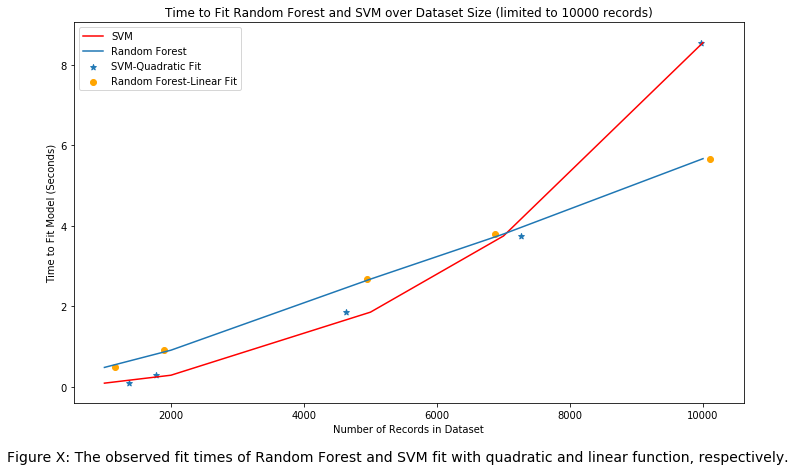

In [198]:
RF_times = pd.read_csv('./data/RF_profiling.csv').query('cores == 1').query('sizes <= 10000')
time_data = pd.read_csv('./data/SVM_profiling.csv').query('sizes <= 10000')

svm_coefs = poly.polyfit(time_data.times, time_data.sizes, 2)
svm_ffit = poly.polyval(time_data.times, svm_coefs)

rf_coefs = poly.polyfit(RF_times.times, RF_times.sizes, 1)
rf_ffit = poly.polyval(RF_times.times, rf_coefs)

plt.figure(figsize=(12,7))
plt.plot(time_data.sizes, time_data.times, c='r', label='SVM')
plt.scatter(svm_ffit, time_data.times, marker='*', label='SVM-Quadratic Fit')

plt.scatter(rf_ffit, RF_times.times, marker='o', c='orange', label='Random Forest-Linear Fit')
plt.plot(RF_times.sizes, RF_times.times, label = 'Random Forest')

plt.ylabel('Time to Fit Model (Seconds)')
plt.xlabel('Number of Records in Dataset')
plt.title('Time to Fit Random Forest and SVM over Dataset Size (limited to 10000 records)');
plt.legend();
caption = 'Figure X: The observed fit times of Random Forest and SVM fit with quadratic and linear function, respectively.'
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=14);
plt.savefig('./images/RF_SVM_Fits_Small.png')